In [63]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [64]:
od.download('https://www.kaggle.com/datasets/wyattowalsh/basketball')

Skipping, found downloaded files in "./basketball" (use force=True to force download)


In [84]:
db_path = './basketball/nba.sqlite'
connection = sqlite3.connect(db_path)

In [68]:
%load_ext sql

%sql sqlite:///basketball/nba.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [70]:
# List all tables to verify the table name
tables = %sql SELECT name FROM sqlite_master WHERE type='table';

tables = [table[0] for table in tables]
tables

   sqlite:///./basketball/nba.sqlite
   sqlite:////mnt/d/DataScience/NBA/basketball/nba.sqlite
 * sqlite:///basketball/nba.sqlite
Done.


['game',
 'game_summary',
 'other_stats',
 'officials',
 'inactive_players',
 'game_info',
 'line_score',
 'play_by_play',
 'player',
 'team',
 'common_player_info',
 'team_details',
 'team_history',
 'draft_combine_stats',
 'draft_history',
 'team_info_common']

In [83]:
%%sql

WITH home_metrics AS 
    (
        SELECT team_abbreviation_home, 
            SUM(fg_pct_home) / COUNT(*) AS season_fg_pct_home, 
            SUM(fg3_pct_home) / COUNT(*) AS season_3pt_pct_home, 
            SUM(tov_home) / COUNT(*) AS season_tov_avg_home, 
            SUM(ast_home) / COUNT(*) AS season_ast_avg_home,
            SUM(ast_home) / SUM(tov_home) AS season_ast_tov_pct_home, 
            SUM(fta_home) / COUNT(*) AS season_avg_fta_game_home, 
            SUM(ft_pct_home) / COUNT(*) AS season_ft_pct_game_home
        FROM game WHERE season_id = '22022' GROUP BY team_abbreviation_home
    ), 
    
    away_metrics AS 
    (
        SELECT team_abbreviation_away, 
            SUM(fg_pct_away) / COUNT(*) AS season_fg_pct_away, 
            SUM(fg3_pct_away) / COUNT(*) AS season_3pt_pct_away, 
            SUM(tov_away) / COUNT(*) AS season_tov_avg_away, 
            SUM(ast_away) / COUNT(*) AS season_ast_avg_away,
            SUM(ast_away) / SUM(tov_away) AS season_ast_tov_pct_away, 
            SUM(fta_away) / COUNT(*) AS season_avg_fta_game_away, 
            SUM(ft_pct_away) / COUNT(*) AS season_ft_pct_game_away
        FROM game WHERE season_id = '22022' GROUP BY team_abbreviation_away
    ), 
    
    team_level_metrics AS 
    (
        SELECT hm.team_abbreviation_home, 
            season_fg_pct_home, 
            season_3pt_pct_home, 
            season_tov_avg_home, 
            season_ast_avg_home, 
            season_ast_tov_pct_home, 
            season_avg_fta_game_home, 
            season_ft_pct_game_home,
            season_fg_pct_away, 
            season_3pt_pct_away, 
            season_tov_avg_away, 
            season_ast_avg_away, 
            season_ast_tov_pct_away, 
            season_avg_fta_game_away, 
            season_ft_pct_game_away
        FROM home_metrics hm JOIN away_metrics am ON hm.team_abbreviation_home = am.team_abbreviation_away
    ), 
    
    game_level_metrics AS 
    (
        SELECT pbp.game_id, 
            g.fta_home + g.fta_away AS total_fta, 
            ABS(g.plus_minus_home) AS abs_plus_minus, 
            pts_home + pts_away AS total_points, 
            COUNT(pbp.eventnum) AS total_pbp 
        FROM play_by_play pbp JOIN game g ON pbp.game_id = g.game_id WHERE g.season_id = '22022' GROUP BY pbp.game_id, g.fta_home, g.fta_away
    ), 
    
    officials_metrics AS 
    (
        SELECT o.first_name || '_' || o.last_name AS full_name, 
            COUNT(o.game_id) AS num_of_games, 
            SUM(total_fta) / COUNT(o.game_id) AS avg_fta, 
            SUM(total_points) / COUNT(o.game_id) AS avg_pts_per_game, 
            SUM(abs_plus_minus) / COUNT(o.game_id) AS avg_score_diff, 
            SUM(total_pbp)/COUNT(o.game_id) AS avg_pbp 
        FROM officials o JOIN game_level_metrics pbp ON o.game_id = pbp.game_id GROUP BY full_name
    ), 
    
    split_officials AS 
    (
        SELECT *, 
            first_name || '_' || last_name AS full_name, 
            ROW_NUMBER() OVER(PARTITION BY game_id ORDER BY last_name ASC) AS row_num
        FROM officials 
    ), 
    
    matchup_metrics AS 
    (
        SELECT CASE 
            WHEN team_abbreviation_home > team_abbreviation_away 
            THEN team_abbreviation_away || '_' || team_abbreviation_home ELSE team_abbreviation_home || '_' || team_abbreviation_away END AS matchup, 
                SUM(fg_pct_home + fg_pct_away) / COUNT(*) AS matchup_fg_pct, 
                SUM(fg3_pct_home + fg3_pct_away) / COUNT(*) AS matchup_3pt_pct, 
                SUM(tov_home + tov_away) / COUNT(*) AS matchup_tov_avg, 
                SUM(ast_home + ast_away) / COUNT(*) AS matchup_ast_avg,
                SUM(ast_home + ast_away) / SUM(tov_home + tov_away) AS matchup_ast_tov_pct, 
                SUM(fta_home + fta_away) / COUNT(*) AS matchup_avg_fta_game, 
                SUM(ft_pct_home + ft_pct_away) / COUNT(*) AS matchup_ft_pct_game
        FROM game WHERE season_id = '22022' GROUP BY matchup
    )
    
SELECT g.game_id, 
    hm.team_abbreviation_home, hm.season_fg_pct_home, hm.season_3pt_pct_home, hm.season_tov_avg_home, hm.season_ast_avg_home, hm.season_ast_tov_pct_home, hm.season_avg_fta_game_home, hm.season_ft_pct_game_home,
    aw.team_abbreviation_away, aw.season_fg_pct_away, aw.season_3pt_pct_away, aw.season_tov_avg_away, aw.season_ast_avg_away, aw.season_ast_tov_pct_away, aw.season_avg_fta_game_away, aw.season_ft_pct_game_away,
    om_1.full_name AS off_1, om_1.num_of_games AS off_1_num_games, om_1.avg_fta AS off_1_avg_fta, om_1.avg_pts_per_game AS off_1_avg_pts_per_game, om_1.avg_score_diff AS off_1_avg_score_diff, om_1.avg_pbp AS off_1_avg_pbp,
    om_2.full_name AS off_2, om_2.num_of_games AS off_2_num_games, om_2.avg_fta AS off_2_avg_fta, om_2.avg_pts_per_game AS off_2_avg_pts_per_game, om_2.avg_score_diff AS off_2_avg_score_diff, om_2.avg_pbp AS off_2_avg_pbp,
    om_3.full_name AS off_3, om_3.num_of_games AS off_3_num_games, om_3.avg_fta AS off_3_avg_fta, om_3.avg_pts_per_game AS off_3_avg_pts_per_game, om_3.avg_score_diff AS off_3_avg_score_diff, om_3.avg_pbp AS off_3_avg_pbp,
    g.pts_home + g.pts_away AS total_game_points, mm.matchup_fg_pct, mm.matchup_3pt_pct, mm.matchup_tov_avg, mm.matchup_ast_avg, mm.matchup_ast_tov_pct, mm.matchup_avg_fta_game, mm.matchup_ft_pct_game
FROM game g 
    JOIN home_metrics hm ON g.team_abbreviation_home = hm.team_abbreviation_home
    JOIN away_metrics aw ON g.team_abbreviation_away = aw.team_abbreviation_away
    JOIN (SELECT * FROM split_officials WHERE row_num = 1) o_1 ON o_1.game_id = g.game_id
    JOIN (SELECT * FROM split_officials WHERE row_num = 2) o_2 ON o_2.game_id = g.game_id
    JOIN (SELECT * FROM split_officials WHERE row_num = 3) o_3 ON o_3.game_id = g.game_id
    JOIN officials_metrics om_1 ON o_1.full_name = om_1.full_name
    JOIN officials_metrics om_2 ON o_2.full_name = om_2.full_name
    JOIN officials_metrics om_3 ON o_3.full_name = om_3.full_name
    JOIN (SELECT g.game_id, CASE WHEN g.team_abbreviation_home > team_abbreviation_away THEN team_abbreviation_away || '_' || team_abbreviation_home ELSE team_abbreviation_home || '_' || team_abbreviation_away END AS matchup FROM game g) match ON g.game_id = match.game_id
    JOIN matchup_metrics mm ON match.matchup = mm.matchup
WHERE g.season_id = '22022';

   sqlite:///./basketball/nba.sqlite
   sqlite:////mnt/d/DataScience/NBA/basketball/nba.sqlite
 * sqlite:///basketball/nba.sqlite
Done.


game_id,team_abbreviation_home,season_fg_pct_home,season_3pt_pct_home,season_tov_avg_home,season_ast_avg_home,season_ast_tov_pct_home,season_avg_fta_game_home,season_ft_pct_game_home,team_abbreviation_away,season_fg_pct_away,season_3pt_pct_away,season_tov_avg_away,season_ast_avg_away,season_ast_tov_pct_away,season_avg_fta_game_away,season_ft_pct_game_away,off_1,off_1_num_games,off_1_avg_fta,off_1_avg_pts_per_game,off_1_avg_score_diff,off_1_avg_pbp,off_2,off_2_num_games,off_2_avg_fta,off_2_avg_pts_per_game,off_2_avg_score_diff,off_2_avg_pbp,off_3,off_3_num_games,off_3_avg_fta,off_3_avg_pts_per_game,off_3_avg_score_diff,off_3_avg_pbp,total_game_points,matchup_fg_pct,matchup_3pt_pct,matchup_tov_avg,matchup_ast_avg,matchup_ast_tov_pct,matchup_avg_fta_game,matchup_ft_pct_game
0022200005,ATL,0.4825609756097561,0.347439024390244,12.658536585365853,25.29268292682927,1.998073217726397,22.26829268292683,0.8225365853658537,HOU,0.4570000000000001,0.3209756097560976,16.24390243902439,23.0,1.4159159159159158,24.951219512195124,0.7547317073170732,Ed_Malloy,38,45.921052631578945,232.60526315789474,11,459,Jenna_Reneau,3,38.333333333333336,239.66666666666666,8,464,Ben_Taylor,56,48.32142857142857,230.375,12,470,224.0,0.938,0.6325000000000001,30.5,47.0,1.540983606557377,58.0,1.7005
0022200020,ATL,0.4825609756097561,0.347439024390244,12.658536585365853,25.29268292682927,1.998073217726397,22.26829268292683,0.8225365853658537,ORL,0.45746341463414636,0.33036585365853655,15.097560975609756,21.75609756097561,1.4410339256865912,24.317073170731707,0.7816341463414636,Brandon_Schwab,31,44.41935483870968,228.90322580645162,11,466,Dedric_Taylor,52,46.48076923076923,229.48076923076923,10,469,Zach_Zarba,56,44.25,230.14285714285714,11,463,206.0,0.97225,0.67875,27.75,52.25,1.882882882882883,48.0,1.73725
0022200038,ATL,0.4825609756097561,0.347439024390244,12.658536585365853,25.29268292682927,1.998073217726397,22.26829268292683,0.8225365853658537,CHA,0.4613414634146342,0.3195121951219513,13.975609756097562,25.048780487804876,1.7923211169284468,23.804878048780488,0.7495121951219512,Nick_Buchert,49,48.46938775510204,227.77551020408163,9,465,Pat_Fraher,48,49.958333333333336,229.02083333333334,7,477,Andy_Nagy,36,44.638888888888886,230.11111111111111,11,459,235.0,1.012,0.8185,28.0,54.0,1.9285714285714286,49.25,1.6315
0022200134,ATL,0.4825609756097561,0.347439024390244,12.658536585365853,25.29268292682927,1.998073217726397,22.26829268292683,0.8225365853658537,NOP,0.47868292682926816,0.3484878048780488,14.585365853658537,25.926829268292682,1.7775919732441472,24.073170731707318,0.79190243902439,JB_DeRosa,52,50.69230769230769,232.51923076923077,10,480,Scott_Foster,47,46.638297872340424,233.2127659574468,10,467,Robert_Hussey,25,47.04,230.04,13,454,245.0,0.9165,0.631,25.5,54.5,2.1372549019607843,49.5,1.4905
0022200162,ATL,0.4825609756097561,0.347439024390244,12.658536585365853,25.29268292682927,1.998073217726397,22.26829268292683,0.8225365853658537,UTA,0.47695121951219505,0.3408048780487804,15.0,26.4390243902439,1.7626016260162602,21.170731707317074,0.7928048780487805,Ray_Acosta,56,46.25,225.32142857142858,9,461,Ashley_Moyer-Gleich,50,47.34,234.36,10,462,James_Williams,51,42.78431372549019,228.45098039215685,13,460,244.0,0.925,0.6435,24.0,49.5,2.0625,38.0,1.5559999999999998
0022200173,ATL,0.4825609756097561,0.347439024390244,12.658536585365853,25.29268292682927,1.998073217726397,22.26829268292683,0.8225365853658537,PHI,0.4954146341463414,0.3837560975609756,13.731707317073171,24.634146341463413,1.7939609236234457,25.170731707317074,0.8302439024390246,Matt_Boland,42,47.95238095238095,228.95238095238096,12,478,Jason_Goldenberg,38,49.26315789473684,235.21052631578948,11,471,Courtney_Kirkland,51,46.0,224.92156862745097,11,468,199.0,0.95875,0.6545,34.75,48.0,1.381294964028777,52.0,1.601
0022200214,ATL,0.4825609756097561,0.347439024390244,12.658536585365853,25.29268292682927,1.998073217726397,22.26829268292683,0.8225365853658537,BOS,0.46819512195121954,0.3729756097560976,12.8536585

In [91]:
dataset_from_sql = _

df = pd.DataFrame(dataset_from_sql)

df

,game_id,team_abbreviation_home,season_fg_pct_home,season_3pt_pct_home,season_tov_avg_home,season_ast_avg_home,season_ast_tov_pct_home,season_avg_fta_game_home,season_ft_pct_game_home,team_abbreviation_away,...,off_3_avg_score_diff,off_3_avg_pbp,total_game_points,matchup_fg_pct,matchup_3pt_pct,matchup_tov_avg,matchup_ast_avg,matchup_ast_tov_pct,matchup_avg_fta_game,matchup_ft_pct_game
0,0022200005,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,HOU,...,12,470,224.0,0.938000,0.632500,30.500000,47.000000,1.540984,58.000000,1.700500
1,0022200020,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,ORL,...,11,463,206.0,0.972250,0.678750,27.750000,52.250000,1.882883,48.000000,1.737250
2,0022200038,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,CHA,...,11,459,235.0,1.012000,0.818500,28.000000,54.000000,1.928571,49.250000,1.631500
3,0022200134,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,NOP,...,13,454,245.0,0.916500,0.631000,25.500000,54.500000,2.137255,49.500000,1.490500
4,0022200162,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,UTA,...,13,460,244.0,0.925000,0.643500,24.000000,49.500000,2.062500,38.000000,1.556000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,0022201098,WAS,0.486415,0.370707,14.170732,25.926829,1.829604,20.926829,0.819049,SAS,...,9,469,260.0,1.048000,0.808000,19.500000,61.000000,3.128205,40.500000,1.432500
1102,0022201130,WAS,0.486415,0.370707,14.170732,25.926829,1.829604,20.926829,0.819049,BOS,...,9,470,241.0,0.986667,0.662667,21.666667,53.666667,2.476923,39.666667,1.675667
1103,0022201151,WAS,0.486415,0.370707,14.170732,25.926829,1.829604,20.926829,0.819049,ORL,...,12,470,225.0,0.979500,0.746250,27.500000,55.500000,2.018182,44.000000,1.596500
1104,0022201179,WAS,0.486415,0.370707,14.170732,25.926829,1.829604,20.926829,0.819049,MIL,...,10,473,268.0,0.935750,0.707750,26.000000,54.750000,2.105769,38.750000,1.616250


In [ ]:
df.to_csv('nba_data.csv', index=False)

---

# Data Understanding

### Problem statement
...

#features and # of instances

class (bin/multi)/reg

### Data visualization
feature histograms

correlation matrix

2/3-dim data visualization for important features

How to change from un- to structured dataset (or data preprocessing)

In [96]:
df = pd.read_csv('nba_data.csv')
df.head()

,game_id,team_abbreviation_home,season_fg_pct_home,season_3pt_pct_home,season_tov_avg_home,season_ast_avg_home,season_ast_tov_pct_home,season_avg_fta_game_home,season_ft_pct_game_home,team_abbreviation_away,...,off_3_avg_score_diff,off_3_avg_pbp,total_game_points,matchup_fg_pct,matchup_3pt_pct,matchup_tov_avg,matchup_ast_avg,matchup_ast_tov_pct,matchup_avg_fta_game,matchup_ft_pct_game
0,22200005,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,HOU,...,12,470,224.0,0.93800,0.63250,30.50,47.00,1.540984,58.00,1.70050
1,22200020,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,ORL,...,11,463,206.0,0.97225,0.67875,27.75,52.25,1.882883,48.00,1.73725
2,22200038,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,CHA,...,11,459,235.0,1.01200,0.81850,28.00,54.00,1.928571,49.25,1.63150
3,22200134,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,NOP,...,13,454,245.0,0.91650,0.63100,25.50,54.50,2.137255,49.50,1.49050
4,22200162,ATL,0.482561,0.347439,12.658537,25.292683,1.998073,22.268293,0.822537,UTA,...,13,460,244.0,0.92500,0.64350,24.00,49.50,2.062500,38.00,1.55600


### Column Descriptions

Below is a description of each column in the DataFrame:

- `game_id`: Unique identifier for each game
- `team_abbreviation_home`: Abbreviation of the home team
- `season_fg_pct_home`: Field goal percentage of the home team for the season
- `season_3pt_pct_home`: Three-point field goal percentage of the home team for the season
- `season_tov_avg_home`: Average turnovers per game for the home team for the season
- `season_ast_avg_home`: Average assists per game for the home team for the season
- `season_ast_tov_pct_home`: Assist to turnover ratio for the home team for the season
- `season_avg_fta_game_home`: Average free throw attempts per game for the home team for the season
- `season_ft_pct_game_home`: Free throw percentage for the home team for the season
- `team_abbreviation_away`: Abbreviation of the away team
- `season_fg_pct_away`: Field goal percentage of the away team for the season
- `season_3pt_pct_away`: Three-point field goal percentage of the away team for the season
- `season_tov_avg_away`: Average turnovers per game for the away team for the season
- `season_ast_avg_away`: Average assists per game for the away team for the season
- `season_ast_tov_pct_away`: Assist to turnover ratio for the away team for the season
- `season_avg_fta_game_away`: Average free throw attempts per game for the away team for the season
- `season_ft_pct_game_away`: Free throw percentage for the away team for the season
- `off_1`: Full name of the first official
- `off_1_num_games`: Number of games officiated by the first official
- `off_1_avg_fta`: Average free throw attempts in games officiated by the first official
- `off_1_avg_pts_per_game`: Average points per game in games officiated by the first official
- `off_1_avg_score_diff`: Average score difference in games officiated by the first official
- `off_1_avg_pbp`: Average play-by-play events in games officiated by the first official
- `off_2`: Full name of the second official
- `off_2_num_games`: Number of games officiated by the second official
- `off_2_avg_fta`: Average free throw attempts in games officiated by the second official
- `off_2_avg_pts_per_game`: Average points per game in games officiated by the second official
- `off_2_avg_score_diff`: Average score difference in games officiated by the second official
- `off_2_avg_pbp`: Average play-by-play events in games officiated by the second official
- `off_3`: Full name of the third official
- `off_3_num_games`: Number of games officiated by the third official
- `off_3_avg_fta`: Average free throw attempts in games officiated by the third official
- `off_3_avg_pts_per_game`: Average points per game in games officiated by the third official
- `off_3_avg_score_diff`: Average score difference in games officiated by the third official
- `off_3_avg_pbp`: Average play-by-play events in games officiated by the third official
- `total_game_points`: Total points scored in the game
- `matchup_fg_pct`: Field goal percentage for the matchup
- `matchup_3pt_pct`: Three-point field goal percentage for the matchup
- `matchup_tov_avg`: Average turnovers per game for the matchup
- `matchup_ast_avg`: Average assists per game for the matchup
- `matchup_ast_tov_pct`: Assist to turnover ratio for the matchup
- `matchup_avg_fta_game`: Average free throw attempts per game for the matchup
- `matchup_ft_pct_game`: Free throw percentage for the matchup

In [93]:
df.describe()

,season_fg_pct_home,season_3pt_pct_home,season_tov_avg_home,season_ast_avg_home,season_ast_tov_pct_home,season_avg_fta_game_home,season_ft_pct_game_home,season_fg_pct_away,season_3pt_pct_away,season_tov_avg_away,...,off_3_avg_score_diff,off_3_avg_pbp,total_game_points,matchup_fg_pct,matchup_3pt_pct,matchup_tov_avg,matchup_ast_avg,matchup_ast_tov_pct,matchup_avg_fta_game,matchup_ft_pct_game
count,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,...,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000
mean,0.481129,0.365351,14.007740,25.656001,1.841291,23.842412,0.782617,0.472152,0.353390,14.179112,...,10.698915,465.741410,229.285714,0.953051,0.719203,28.179325,50.729732,1.832751,47.068641,1.563256
std,0.012588,0.015089,1.155293,1.890659,0.170797,1.679408,0.030312,0.014279,0.017841,1.089453,...,1.309464,6.751306,19.268517,0.048733,0.071532,3.782724,4.688116,0.300348,6.215255,0.085237
min,0.455341,0.325317,11.609756,21.756098,1.339339,20.073171,0.735780,0.446098,0.319512,11.707317,...,6.000000,449.000000,169.000000,0.818000,0.486000,18.000000,36.000000,1.148649,28.000000,1.233500
25%,0.474634,0.356000,13.121951,24.341463,1.751269,22.853659,0.759683,0.461341,0.338927,13.219512,...,10.000000,462.000000,217.000000,0.919000,0.666500,26.000000,47.083333,1.629774,42.500000,1.508500
50%,0.481439,0.365780,13.853659,25.560976,1.851730,23.707317,0.778463,0.470585,0.350927,14.073171,...,11.000000,465.000000,229.000000,0.949500,0.717750,28.000000,50.500000,1.798165,47.000000,1.564750
75%,0.486073,0.377439,14.829268,26.585366,1.934985,25.536585,0.799195,0.484805,0.367195,15.000000,...,12.000000,470.000000,242.000000,0.986667,0.771500,30.750000,54.000000,2.018519,51.500000,1.621000
max,0.514805,0.390683,16.243902,30.487805,2.142056,26.512195,0.847854,0.497073,0.383756,16.829268,...,14.000000,518.000000,290.000000,1.095000,0.962500,40.750000,66.000000,3.128205,65.500000,1.791000


In [97]:
df.shape

(1106, 43)

<Axes: xlabel='total_game_points', ylabel='Count'>

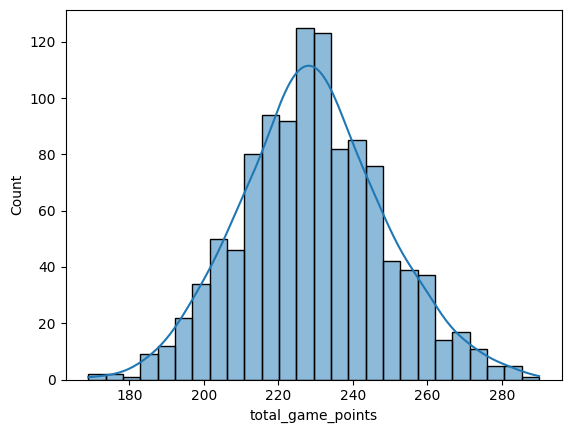

In [98]:
sns.histplot(df['total_game_points'], kde=True)

# Feature Selection / Reduction

SelectKbest, regularization, or RFECV etc

Decision (why 'M' features are removed)

# Model Building / Selection

What are the baseline and target (estimators) among your estimators? (The baseline will be chosen from linear models, and the target from your Ref. paper(s))

Using covered all the methods. At least 6 categories/types of 
1. Linear Models (LR, Poly-LR / LDA), 
2. with Regularization (Ridge / Lasso) methods; 
3. Tree-based models; 
4. Ensemble (bagging and boosting) 
5. SVM 
6. kNN

Requirement: At least 8-9 estimators

--- 

Systematic Cross-Validation.
Requirements: 
1. a Search Space Table for hyper-parameters (HP), 
2. HP priority (or Global search),  
3. selection with  a local optimal point for each HP comparing training and validation errors (scores) in each estimator, 
4. the total training time of each estimator for all HPs, and 
5. the best among all the estimators w.r.t Val.

---

For the CVs, fully visualized improving readability? (Requirement: a local optimal point (not coninuous), comparing training and validation errors)

---

model comparison, analyses, and  selection with the best validation results (and next steps, if any)? Takeaways (overall conclusions in training phase)



# Results with Test

Requirement: Results comparing test (and w/ training/validation) datasets, and analyzing/checking problematic issues (e.g., overfitting) or/and Takeaways (overall conclusions in test phase). 